In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
##Generate data
env = gym.make('CartPole-v1')

In [3]:
with open('transitions_optimal100.pkl', 'rb') as f:
   transitions_optimal100 = pickle.load(f)
with open('transitions_optimal250.pkl', 'rb') as f:
   transitions_optimal250 = pickle.load(f)
with open('transitions_optimal500.pkl', 'rb') as f:
   transitions_optimal500 = pickle.load(f)
with open('transitions_random100.pkl', 'rb') as f:
   transitions_random100 = pickle.load(f)
with open('transitions_random250.pkl', 'rb') as f:
   transitions_random250 = pickle.load(f)
with open('transitions_random500.pkl', 'rb') as f:
   transitions_random500 = pickle.load(f)

In [6]:
#class for imitation learnign using logisti regression
class ImitationLearning:
    def __init__(self, dataset="optimal",c=0.5):
        self.env = gym.make('CartPole-v1')
        # self.transitions_optimal = transitions_optimal
        # self.transitions_random = transitions_random
        self.c = c
        self.logistic = LogisticRegression(solver="lbfgs", max_iter=1000)
        self.dataset = dataset
    def rollout_transitions_optimal(self, transitions_optimal):
        states = []
        actions = []
        dones = []
        for transition in transitions_optimal:
            states.append(transition[0])
            actions.append(transition[1])
            dones.append(transition[4])
        return np.array(states), np.array(actions), np.array(dones)
    def rollout_transitions_random(self, transitions_random):
        states = []
        actions = []
        dones = []
        for transition in transitions_random:
            states.append(transition[0])
            actions.append(transition[1])
            dones.append(transition[4])
        return np.array(states), np.array(actions), np.array(dones)
    
    def rollout_transitions_mixed(self, transitions_optimal, transitions_random):
        states_optimal, actions_optimal, dones_optimal = self.rollout_transitions_optimal(transitions_optimal)
        states_random, actions_random, dones_random = self.rollout_transitions_random(transitions_random)
        actions_random = np.reshape(actions_random, (len(actions_random), 1))
        i_optimal = np.where(dones_optimal == True)[0]
        i_random = np.where(dones_random == True)[0]
        #make the first element of half i_optimal and i_random 0
        i_optimal = np.insert(i_optimal, 0, 0)
        i_random = np.insert(i_random, 0, 0)
        #Take first half of the i_optimal and i_random
        half_i_optimal = i_optimal[:len(i_optimal)//2]#when the first x episodes end
        half_i_random = i_random[:len(i_random)//2] #when the first x episodes end

        #store episodes from optimal and random
        states_optimal_episodes = []
        actions_optimal_episodes = []
        states_random_episodes = []
        actions_random_episodes = []

        for i in range(len(half_i_optimal)-1):
            states_optimal_episodes.append(states_optimal[half_i_optimal[i]:half_i_optimal[i+1]])
            actions_optimal_episodes.append(actions_optimal[half_i_optimal[i]:half_i_optimal[i+1]])
            states_random_episodes.append(states_random[half_i_random[i]:half_i_random[i+1]])
            actions_random_episodes.append(actions_random[half_i_random[i]:half_i_random[i+1]])
        states_optimal_episodes = np.vstack(states_optimal_episodes)
        actions_optimal_episodes = np.vstack(actions_optimal_episodes)
        states_random_episodes = np.vstack(states_random_episodes)
        actions_random_episodes = np.vstack(actions_random_episodes)


        states = np.concatenate((states_optimal_episodes, states_random_episodes))
        actions = np.concatenate((actions_optimal_episodes, actions_random_episodes)) 

        return states, actions 

    def train(self, transitions_optimal, transitions_random):
        "Returns the mean cross validation score, and the test accuracy"
        if self.dataset == "optimal":
            states, actions,_ = self.rollout_transitions_optimal(transitions_optimal)
        elif self.dataset == "random":
            states, actions,_ = self.rollout_transitions_random(transitions_random)
        else:
            states, actions = self.rollout_transitions_mixed(transitions_optimal, transitions_random)
        X_train, X_test, y_train, y_test = train_test_split(states, actions, test_size=0.2, random_state=42)
        self.logistic.fit(X_train, y_train.ravel())
        scores = cross_val_score(self.logistic, X_train, y_train.ravel(), cv=5)
        y_pred = self.logistic.predict(X_test)
        return scores.mean(), accuracy_score(y_test, y_pred)
    def test(self, num_episodes):
        "Imitation learning on 100 episodes  "
        rewards = np.zeros(num_episodes)
        action_values = np.array([0,1])
        for episode in range(num_episodes):
            state = self.env.reset()[0]
            done = False
            while not done:
                action = self.logistic.predict(state.reshape(1,-1))
                next_state, reward, done, _, _ = self.env.step(np.argmax(action_values*action))
                state = next_state
                rewards[episode] += reward
        
        print(f"Mean reward for  {self.dataset} dataset for {num_episodes} Number of Episodes : {np.mean(rewards)}")
        print(f"Standard deviation  {self.dataset} dataset for {num_episodes} Number of Episodes : {np.std(rewards)}")
        return rewards
        

In [8]:
imitation_optimal_1001  = ImitationLearning( dataset="optimal", c=1)
imitation_optimal_2501  = ImitationLearning( dataset="optimal", c=1)
imitation_optimal_5001  = ImitationLearning(dataset="optimal", c=1)
imitation_random_1001  = ImitationLearning( dataset="random", c=1)
imitation_random_2501  = ImitationLearning( dataset="random", c=1)
imitation_random_5001 = ImitationLearning( dataset="random", c=1)
imitation_mixed_1001  = ImitationLearning(  dataset="mixed", c=1)
imitation_mixed_2501  = ImitationLearning( dataset="mixed", c=1)
imitation_mixed_5001  = ImitationLearning(  dataset="mixed", c=1)

In [9]:
imitation_optimal_1002  = ImitationLearning( dataset="optimal", c=0.5)
imitation_optimal_2502  = ImitationLearning( dataset="optimal", c=0.5)
imitation_optimal_5002  = ImitationLearning(dataset="optimal", c=0.5)
imitation_random_1002  = ImitationLearning( dataset="random", c=0.5)
imitation_random_2502  = ImitationLearning( dataset="random", c=0.5)
imitation_random_5002 = ImitationLearning( dataset="random", c=0.5)
imitation_mixed_1002  = ImitationLearning(  dataset="mixed", c=0.5)
imitation_mixed_2502  = ImitationLearning( dataset="mixed", c=0.5)
imitation_mixed_5002  = ImitationLearning(  dataset="mixed", c=0.5)

In [10]:
scores_optimal_1001, test_accuracy_optimal_1001 = imitation_optimal_1001.train(transitions_optimal=transitions_optimal100, transitions_random = transitions_random100)
scores_optimal_2501, test_accuracy_optimal_2501 = imitation_optimal_2501.train(transitions_optimal=transitions_optimal250, transitions_random = transitions_random250)
scores_optimal_5001, test_accuracy_optimal_5001 = imitation_optimal_5001.train( transitions_optimal=transitions_optimal500, transitions_random = transitions_random500)
scores_random_1001, test_accuracy_random_1001 = imitation_random_1001.train( transitions_optimal=transitions_optimal100, transitions_random = transitions_random100)
scores_random_2501, test_accuracy_random_2501 = imitation_random_2501.train(transitions_optimal=transitions_optimal250, transitions_random = transitions_random250)
scores_random_5001, test_accuracy_random_5001 = imitation_random_5001.train(transitions_optimal=transitions_optimal500, transitions_random = transitions_random500)
scores_mixed_1001, test_accuracy_mixed_1001 = imitation_mixed_1001.train(transitions_optimal=transitions_optimal100, transitions_random = transitions_random100)
scores_mixed_2501, test_accuracy_mixed_2501 = imitation_mixed_2501.train( transitions_optimal=transitions_optimal250, transitions_random = transitions_random250,)
scores_mixed_5001, test_accuracy_mixed_5001 = imitation_mixed_5001.train(transitions_optimal=transitions_optimal500, transitions_random = transitions_random500)

In [11]:
scores_optimal_1002, test_accuracy_optimal_1002 = imitation_optimal_1002.train(transitions_optimal=transitions_optimal100, transitions_random = transitions_random100)
scores_optimal_2502, test_accuracy_optimal_2502 = imitation_optimal_2502.train(transitions_optimal=transitions_optimal250, transitions_random = transitions_random250)
scores_optimal_5002, test_accuracy_optimal_5002 = imitation_optimal_5002.train( transitions_optimal=transitions_optimal500, transitions_random = transitions_random500)
scores_random_1002, test_accuracy_random_1002 = imitation_random_1002.train( transitions_optimal=transitions_optimal100, transitions_random = transitions_random100)
scores_random_2502, test_accuracy_random_2502 = imitation_random_2502.train(transitions_optimal=transitions_optimal250, transitions_random = transitions_random250)
scores_random_5002, test_accuracy_random_5002 = imitation_random_5002.train(transitions_optimal=transitions_optimal500, transitions_random = transitions_random500)
scores_mixed_1002, test_accuracy_mixed_1002 = imitation_mixed_1002.train(transitions_optimal=transitions_optimal100, transitions_random = transitions_random100)
scores_mixed_2502, test_accuracy_mixed_2502 = imitation_mixed_2502.train( transitions_optimal=transitions_optimal250, transitions_random = transitions_random250,)
scores_mixed_5002, test_accuracy_mixed_5002 = imitation_mixed_5002.train(transitions_optimal=transitions_optimal500, transitions_random = transitions_random500)

In [12]:
rewards_optimal_1001 = imitation_optimal_1001.test(100)
rewards_optimal_2501 = imitation_optimal_2501.test(250)
rewards_optimal_5001 = imitation_optimal_5001.test(500)
rewards_random_1001 = imitation_random_1001.test(100)
rewards_random_2501 = imitation_random_2501.test(250)
rewards_random_5001 = imitation_random_5001.test(500)
rewards_mixed_1001 = imitation_mixed_1001.test(100)
rewards_mixed_2501 = imitation_mixed_2501.test(250)
rewards_mixed_5001 = imitation_mixed_5001.test(500)

Mean reward for  optimal dataset for 100 Number of Episodes : 199.76
Standard deviation  optimal dataset for 100 Number of Episodes : 46.72154107047412
Mean reward for  optimal dataset for 250 Number of Episodes : 202.028
Standard deviation  optimal dataset for 250 Number of Episodes : 48.82543615780611
Mean reward for  optimal dataset for 500 Number of Episodes : 207.976
Standard deviation  optimal dataset for 500 Number of Episodes : 54.875599532032446
Mean reward for  random dataset for 100 Number of Episodes : 9.88
Standard deviation  random dataset for 100 Number of Episodes : 0.4534313619501853
Mean reward for  random dataset for 250 Number of Episodes : 9.896
Standard deviation  random dataset for 250 Number of Episodes : 0.511061640117902
Mean reward for  random dataset for 500 Number of Episodes : 9.928
Standard deviation  random dataset for 500 Number of Episodes : 0.4886880395507956
Mean reward for  mixed dataset for 100 Number of Episodes : 33.69
Standard deviation  mixed d

In [13]:
rewards_optimal_1002 = imitation_optimal_1002.test(100)
rewards_optimal_2502 = imitation_optimal_2502.test(250)
rewards_optimal_5002 = imitation_optimal_5002.test(500)
rewards_random_1002 = imitation_random_1002.test(100)
rewards_random_2502 = imitation_random_2502.test(250)
rewards_random_5002 = imitation_random_5002.test(500)
rewards_mixed_1002 = imitation_mixed_1002.test(100)
rewards_mixed_2502 = imitation_mixed_2502.test(250)
rewards_mixed_5002 = imitation_mixed_5002.test(500)

Mean reward for  optimal dataset for 100 Number of Episodes : 206.11
Standard deviation  optimal dataset for 100 Number of Episodes : 52.89591572134847
Mean reward for  optimal dataset for 250 Number of Episodes : 206.924
Standard deviation  optimal dataset for 250 Number of Episodes : 51.480542188287025
Mean reward for  optimal dataset for 500 Number of Episodes : 207.568
Standard deviation  optimal dataset for 500 Number of Episodes : 53.98793731936792
Mean reward for  random dataset for 100 Number of Episodes : 9.88
Standard deviation  random dataset for 100 Number of Episodes : 0.49558046773455466
Mean reward for  random dataset for 250 Number of Episodes : 9.908
Standard deviation  random dataset for 250 Number of Episodes : 0.45993042952168317
Mean reward for  random dataset for 500 Number of Episodes : 9.884
Standard deviation  random dataset for 500 Number of Episodes : 0.48429742927254943
Mean reward for  mixed dataset for 100 Number of Episodes : 35.5
Standard deviation  mixe

In [33]:
def discretize_state(state, num_bins=5):
    lower_bounds = [-4.8, -2.5, -0.418, -3.8]
    upper_bounds = [4.8, 2.5, 0.418, 3.7]
    
    bins = [np.linspace(low, up, num_bins)[1:] for low, up in zip(lower_bounds, upper_bounds)]

    state_clipped = np.clip(state, lower_bounds, upper_bounds)

    idx = [np.digitize(s, b) for s, b in zip(state_clipped, bins)]

    one_hot = [np.eye(num_bins)[i] for i in idx]
    
    return np.concatenate(one_hot)

#discretize_state((-4.8, -2.5, -0.418, -3.8))
#discretize_state((4.8, 2.5, 0.418, 3.7))

In [99]:
class FQLearner:
    def __init__(self, learning_rate, num_iteratation, gamma = 0.90, num_bins = 5, num_actions = 2, dataset = "optimal"):
        self.num_states = num_bins * 4
        self.num_actions = num_actions
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.num_iteratation = num_iteratation
        self.weights = np.random.uniform(-0.001, 0.001, size = (self.num_states, self.num_actions)) #40x2
        self.dataset = dataset

    def rollout_transitions_optimal(self, transitions):
        states = []
        actions = []
        rewards = []
        dones = []
        next_states = []
        score = 0
        for transition in transitions:
            states.append(transition[0])
            actions.append(transition[1])
            next_states.append(transition[3])
            done = transition[4]
            if not done:
                score += transition[2]
            else:
                score = 0
            rewards.append(score)
            dones.append(transition[4])
        # print(rewards)
        return np.array(states), np.array(actions), np.array(rewards),np.array(next_states), np.array(dones)
    
    def rollout_transitions_optimal(self, transitions_optimal):
        states = []
        actions = []
        dones = []
        next_states = []
        rewards = []
        score =  0
        for transition in transitions_optimal:
            states.append(transition[0])
            actions.append(transition[1])
            next_states.append(transition[3])
            done = transition[4]
            if not done:
                score += transition[2]
            else:
                score = 0
            rewards.append(score)
            dones.append(transition[4])
        return np.array(states), np.array(actions), np.array(rewards),np.array(next_states), np.array(dones)
    def rollout_transitions_random(self, transitions_random):
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        for transition in transitions_random:
            states.append(transition[0])
            actions.append(transition[1])
            next_states.append(transition[3])
            done = transition[4]
            score = 0
            if not done:
                score += transition[2]
            else:
                score = 0
            rewards.append(score)
            dones.append(transition[4])
        return np.array(states), np.array(actions), np.array(rewards),np.array(next_states), np.array(dones)
    
    def rollout_transitions_mixed(self, transitions_optimal, transitions_random):
        indices_optimal = random.sample(range(len(transitions_optimal)), len(transitions_optimal)//2)
        indices_random = random.sample(range(len(transitions_random)), len(transitions_random)//2)
        optimal_subset = [transitions_optimal[i] for i in indices_optimal]
        random_subset = [transitions_random[i] for i in indices_random]
        transitions = optimal_subset + random_subset
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        for transition in transitions:
            states.append(transition[0][0])
            actions.append(transition[1])
            rewards.append(transition[2])
            next_states.append(transition[3][0])
            dones.append(transition[4])
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    
    def train(self, transitions_optimal100, transitions_random100):
        if self.dataset == "optimal":
            states, actions, rewards, next_states, dones = self.rollout_transitions_optimal(transitions_optimal100)
            training_error = np.zeros((states.shape[0], self.num_iteratation))
            # score = 0
        elif self.dataset == "random":
            states, actions, rewards, next_states, dones = self.rollout_transitions_random(transitions_random100)
            training_error = np.zeros((states.shape[0], self.num_iteratation))

        elif self.dataset == "optimal_random":
            states, actions, rewards, next_states, dones = self.rollout_transitions_mixed(transitions_optimal100, transitions_random100)
            training_error = np.zeros((states.shape[0], self.num_iteratation))

        for i in tqdm(range(states.shape[0])):
            target = rewards[i] + self.gamma * np.max(self.predict(discretize_state(next_states[i]))) * (1 - dones[i])
            error_epoch = []
            for epoch in range(self.num_iteratation):
                state = discretize_state(states[i])
                q =  np.dot(state, self.weights)[int(actions[i])]
                error = q-target
                training_error[i, epoch] = abs(error)
                self.weights[:, int(actions[i])] -= self.learning_rate * error * discretize_state(states[i])
            # training_error.append(error_epoch/self.num_iteratation)
        weights = self.weights
        return  training_error, weights
    def action(self, state, train=False):
        #take greedy action for evaluation
        return np.argmax(self.predict(discretize_state(state)))
        
    def test(self, num_episodes, env):
        rewards = np.zeros(num_episodes)
        for episode in range(num_episodes):
            state = env.reset()[0]
            done = False
            total_reward = 0
            while not done:
                action = self.action(state)
                next_state, reward, done, _, _ = env.step(action)
                state = next_state
                rewards[episode] += reward
            # rewards.append(total_reward)
        print(f"Mean reward for  {self.dataset} dataset for {num_episodes} Number of Episodes : {np.mean(rewards)}")
        print(f"Standard deviation  {self.dataset} dataset for {num_episodes} Number of Episodes : {np.std(rewards)}")
        
        return rewards
    def predict(self, state):
        return np.dot(state, self.weights) #1x40 * 40x2 = 1x2

In [100]:
Q_optimal1 = FQLearner(learning_rate=1/8, num_iteratation=10, gamma=0.99, dataset="optimal")
Q_random1 = FQLearner(learning_rate=1/8, num_iteratation=10, gamma=0.99, dataset="random")
Q_mixed1 = FQLearner(learning_rate=1/8, num_iteratation=10, gamma=0.99, dataset="optimal_random")

In [101]:
Q_optimal2 = FQLearner(learning_rate=1/16, num_iteratation=20, gamma=0.99, dataset="optimal")
Q_random2 = FQLearner(learning_rate=1/16, num_iteratation=20, gamma=0.99, dataset="random")
Q_mixed2 = FQLearner(learning_rate=1/16, num_iteratation=20, gamma=0.99, dataset="optimal_random")

In [102]:
error_optimal_1001, weights_optimal_1001 = Q_optimal1.train(transitions_optimal100, transitions_random100)
error_optimal_2501, weights_optimal_2501 = Q_optimal1.train(transitions_optimal250, transitions_random250)
error_optimal_5001, weights_optimal_5001 = Q_optimal1.train(transitions_optimal500, transitions_random500)


100%|██████████| 113845/113845 [04:04<00:00, 466.16it/s]


In [103]:
error_random_1001, weights_random_1001 = Q_random1.train(transitions_optimal100, transitions_random100)
error_random_2501, weights_random_2501 = Q_random1.train(transitions_optimal250, transitions_random250)
error_random_5001, weights_random_5001 = Q_random1.train(transitions_optimal500, transitions_random500)


100%|██████████| 10860/10860 [00:23<00:00, 466.52it/s]


In [104]:
error_mixed_1001, weights_mixed_1001 = Q_mixed1.train(transitions_optimal100, transitions_random100)
error_mixed_2501, weights_mixed_2501 = Q_mixed1.train(transitions_optimal250, transitions_random250)
error_mixed_5001, weights_mixed_5001 = Q_mixed1.train(transitions_optimal500, transitions_random500)

C:\Users\vrajp\AppData\Local\Temp\ipykernel_2844\1868522030.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)
100%|██████████| 62352/62352 [02:16<00:00, 455.22it/s]


In [105]:
error_optimal_1002, weights_optimal_1002 = Q_optimal2.train(transitions_optimal100, transitions_random100)
error_optimal_2502, weights_optimal_2502 = Q_optimal2.train(transitions_optimal250, transitions_random250)
error_optimal_5002, weights_optimal_5002 = Q_optimal2.train(transitions_optimal500, transitions_random500)

100%|██████████| 113845/113845 [08:05<00:00, 234.64it/s]


In [106]:
error_random_1002, weights_random_1002 = Q_random2.train(transitions_optimal100, transitions_random100)
error_random_2502, weights_random_2502 = Q_random2.train(transitions_optimal250, transitions_random250)
error_random_5002, weights_random_5002 = Q_random2.train(transitions_optimal500, transitions_random500)

100%|██████████| 10860/10860 [00:45<00:00, 236.20it/s]


In [107]:
error_mixed_1002, weights_mixed_1002 = Q_mixed2.train(transitions_optimal100, transitions_random100)
error_mixed_2502, weights_mixed_2502 = Q_mixed2.train(transitions_optimal250, transitions_random250)
error_mixed_5002, weights_mixed_5002 = Q_mixed2.train(transitions_optimal500, transitions_random500)

C:\Users\vrajp\AppData\Local\Temp\ipykernel_2844\1868522030.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)
100%|██████████| 62352/62352 [04:33<00:00, 228.06it/s]


In [108]:
q_rewards_optimal_1001 = Q_optimal1.test(100, env)
q_rewards_optimal_2501 = Q_optimal1.test(250, env)
q_rewards_optimal_5001 = Q_optimal1.test(500, env)
q_rewards_random_1001 = Q_random1.test(100, env)
q_rewards_random_2501 = Q_random1.test(250, env)
q_rewards_random_5001 = Q_random1.test(500, env)
q_rewards_mixed_1001 = Q_mixed1.test(100, env)
q_rewards_mixed_2501 = Q_mixed1.test(250, env)
q_rewards_mixed_5001 = Q_mixed1.test(500, env)

Mean reward for  optimal dataset for 100 Number of Episodes : 29.86
Standard deviation  optimal dataset for 100 Number of Episodes : 40.01900048726854
Mean reward for  optimal dataset for 250 Number of Episodes : 44.236
Standard deviation  optimal dataset for 250 Number of Episodes : 53.21597790137846
Mean reward for  optimal dataset for 500 Number of Episodes : 33.956
Standard deviation  optimal dataset for 500 Number of Episodes : 46.987722481516386
Mean reward for  random dataset for 100 Number of Episodes : 9.31
Standard deviation  random dataset for 100 Number of Episodes : 0.8797158632194829
Mean reward for  random dataset for 250 Number of Episodes : 9.424
Standard deviation  random dataset for 250 Number of Episodes : 0.8510135134062208
Mean reward for  random dataset for 500 Number of Episodes : 9.506
Standard deviation  random dataset for 500 Number of Episodes : 0.8751936928474747
Mean reward for  optimal_random dataset for 100 Number of Episodes : 9.23
Standard deviation  o

In [109]:
q_rewards_optimal_1002 = Q_optimal2.test(100, env)
q_rewards_optimal_2502 = Q_optimal2.test(250, env)
q_rewards_optimal_5002 = Q_optimal2.test(500, env)
q_rewards_random_1002 = Q_random2.test(100, env)
q_rewards_random_2502 = Q_random2.test(250, env)
q_rewards_random_5002 = Q_random2.test(500, env)
q_rewards_mixed_1002 = Q_mixed2.test(100, env)
q_rewards_mixed_2502 = Q_mixed2.test(250, env)
q_rewards_mixed_5002 = Q_mixed2.test(500, env)

Mean reward for  optimal dataset for 100 Number of Episodes : 37.31
Standard deviation  optimal dataset for 100 Number of Episodes : 48.94173985464759
Mean reward for  optimal dataset for 250 Number of Episodes : 33.684
Standard deviation  optimal dataset for 250 Number of Episodes : 45.80724990653772
Mean reward for  optimal dataset for 500 Number of Episodes : 30.628
Standard deviation  optimal dataset for 500 Number of Episodes : 41.85495927605234
Mean reward for  random dataset for 100 Number of Episodes : 9.46
Standard deviation  random dataset for 100 Number of Episodes : 0.9425497334358544
Mean reward for  random dataset for 250 Number of Episodes : 9.488
Standard deviation  random dataset for 250 Number of Episodes : 0.9087661965544274
Mean reward for  random dataset for 500 Number of Episodes : 9.532
Standard deviation  random dataset for 500 Number of Episodes : 0.917047436068604
Mean reward for  optimal_random dataset for 100 Number of Episodes : 237.27
Standard deviation  o

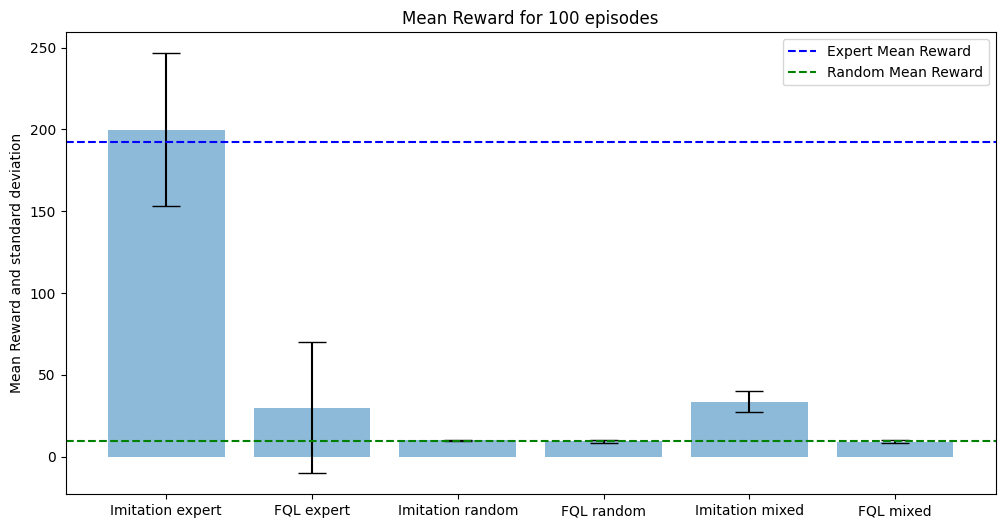

In [110]:
fig, ax = plt.subplots()
ax.bar([0,1,2,3,4,5], [np.mean(rewards_optimal_1001), np.mean(q_rewards_optimal_1001), np.mean(rewards_random_1001), np.mean(q_rewards_random_1001), np.mean(rewards_mixed_1001), np.mean(q_rewards_mixed_1001)], yerr=[np.std(rewards_optimal_1001), np.std(q_rewards_optimal_1001), np.std(rewards_random_1001), np.std(q_rewards_random_1001), np.std(rewards_mixed_1001), np.std(q_rewards_mixed_1001)], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean Reward and standard deviation')
ax.set_xticks([0,1,2,3,4,5])  
ax.set_xticklabels(['Imitation expert',"FQL expert" ,'Imitation random', 'FQL random', 'Imitation mixed', 'FQL mixed'], fontsize=10)
ax.set_title('Mean Reward for 100 episodes')
ax.axhline(y=192.34, color='blue', linestyle='--', label='Expert Mean Reward')
ax.axhline(y=9.55, color='green', linestyle='--', label='Random Mean Reward')
ax.legend()
fig.set_size_inches(12, 6)

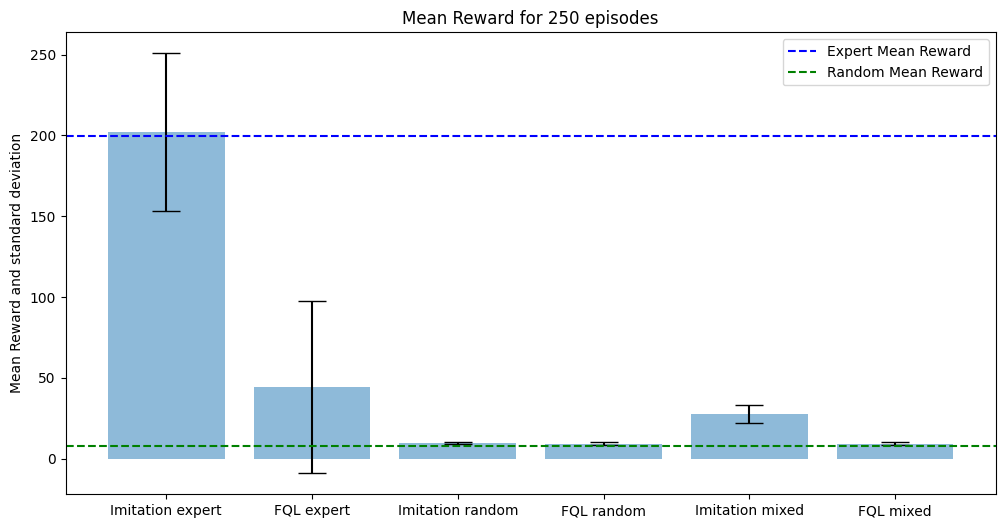

In [111]:
fig, ax = plt.subplots()
ax.bar([0,1,2,3,4,5], [np.mean(rewards_optimal_2501), np.mean(q_rewards_optimal_2501), np.mean(rewards_random_2501), np.mean(q_rewards_random_2501), np.mean(rewards_mixed_2501), np.mean(q_rewards_mixed_2501)], yerr=[np.std(rewards_optimal_2501), np.std(q_rewards_optimal_2501), np.std(rewards_random_2501), np.std(q_rewards_random_2501), np.std(rewards_mixed_2501), np.std(q_rewards_mixed_2501)], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean Reward and standard deviation')
ax.set_xticks([0,1,2,3,4,5])  
ax.set_xticklabels(['Imitation expert',"FQL expert", 'Imitation random', 'FQL random', 'Imitation mixed', 'FQL mixed'], fontsize=10)
ax.set_title('Mean Reward for 250 episodes')
ax.axhline(y=199.9, color='blue', linestyle='--', label='Expert Mean Reward')
ax.axhline(y=8.2, color='green', linestyle='--', label='Random Mean Reward')
ax.legend()
fig.set_size_inches(12, 6)

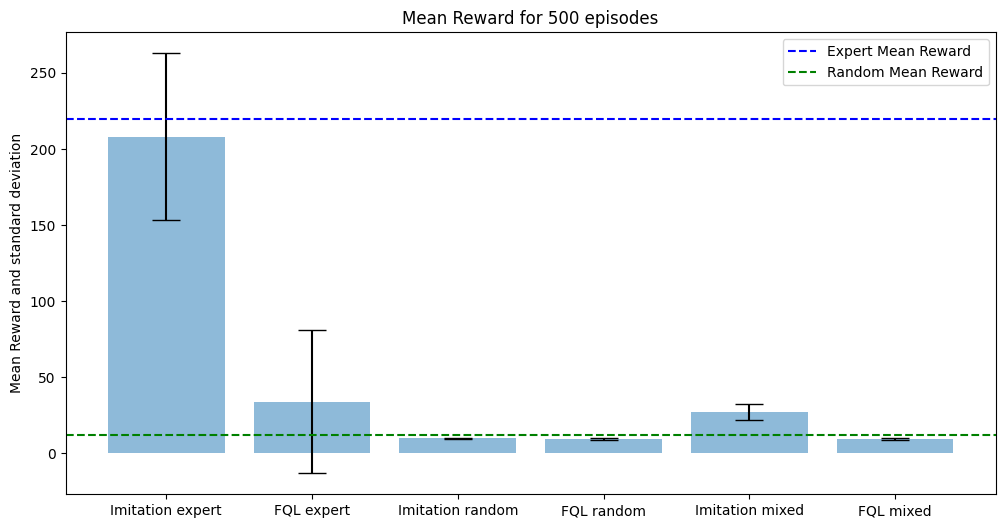

In [112]:
#for 500 episodes
fig, ax = plt.subplots()
ax.bar([0,1,2,3,4,5], [np.mean(rewards_optimal_5001), np.mean(q_rewards_optimal_5001), np.mean(rewards_random_5001), np.mean(q_rewards_random_5001), np.mean(rewards_mixed_5001), np.mean(q_rewards_mixed_5001)], yerr=[np.std(rewards_optimal_5001), np.std(q_rewards_optimal_5001), np.std(rewards_random_5001), np.std(q_rewards_random_5001), np.std(rewards_mixed_5001), np.std(q_rewards_mixed_5001)], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean Reward and standard deviation')
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['Imitation expert',"FQL expert", 'Imitation random', 'FQL random', 'Imitation mixed', 'FQL mixed'], fontsize=10)
ax.set_title('Mean Reward for 500 episodes')
ax.axhline(y=220, color='blue', linestyle='--', label='Expert Mean Reward')
ax.axhline(y=12, color='green', linestyle='--', label='Random Mean Reward')
ax.legend()
fig.set_size_inches(12, 6)

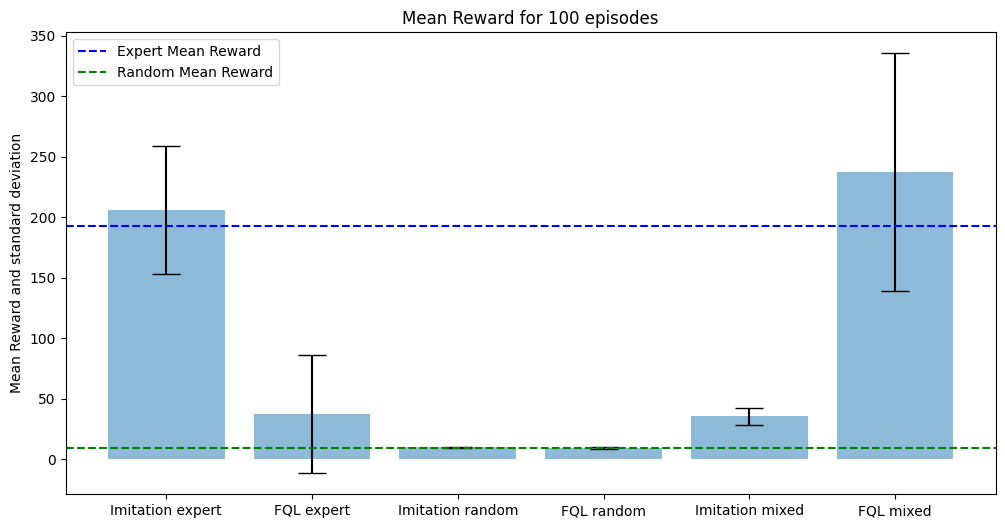

In [113]:
fig, ax = plt.subplots()
ax.bar([0,1,2,3,4,5], [np.mean(rewards_optimal_1002), np.mean(q_rewards_optimal_1002), np.mean(rewards_random_1002), np.mean(q_rewards_random_1002), np.mean(rewards_mixed_1002), np.mean(q_rewards_mixed_1002)], yerr=[np.std(rewards_optimal_1002), np.std(q_rewards_optimal_1002), np.std(rewards_random_1002), np.std(q_rewards_random_1002), np.std(rewards_mixed_1002), np.std(q_rewards_mixed_1002)], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean Reward and standard deviation')
ax.set_xticks([0,1,2,3,4,5])  
ax.set_xticklabels(['Imitation expert',"FQL expert", 'Imitation random', 'FQL random', 'Imitation mixed', 'FQL mixed'], fontsize=10)
ax.set_title('Mean Reward for 100 episodes')
ax.axhline(y=192.34, color='blue', linestyle='--', label='Expert Mean Reward')
ax.axhline(y=9.55, color='green', linestyle='--', label='Random Mean Reward')
ax.legend()
fig.set_size_inches(12, 6)

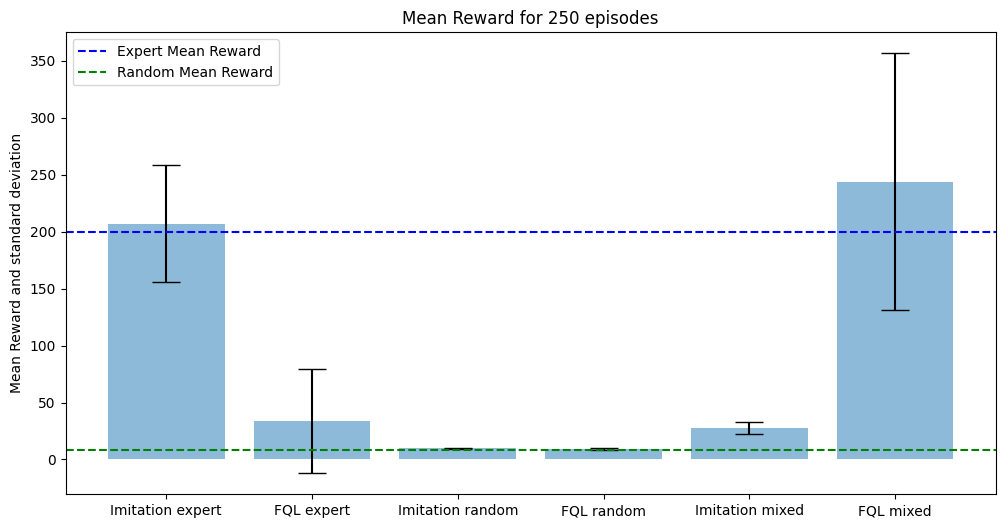

In [114]:
#for 250 episodes
fig, ax = plt.subplots()
ax.bar([0,1,2,3,4,5], [np.mean(rewards_optimal_2502), np.mean(q_rewards_optimal_2502), np.mean(rewards_random_2502), np.mean(q_rewards_random_2502), np.mean(rewards_mixed_2502), np.mean(q_rewards_mixed_2502)], yerr=[np.std(rewards_optimal_2502), np.std(q_rewards_optimal_2502), np.std(rewards_random_2502), np.std(q_rewards_random_2502), np.std(rewards_mixed_2502), np.std(q_rewards_mixed_2502)], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean Reward and standard deviation')
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['Imitation expert',"FQL expert", 'Imitation random', 'FQL random', 'Imitation mixed', 'FQL mixed'], fontsize = 10)
ax.set_title('Mean Reward for 250 episodes')
ax.axhline(y=199.9, color='blue', linestyle='--', label='Expert Mean Reward')
ax.axhline(y=8.2, color='green', linestyle='--', label='Random Mean Reward')
ax.legend()
fig.set_size_inches(12, 6)

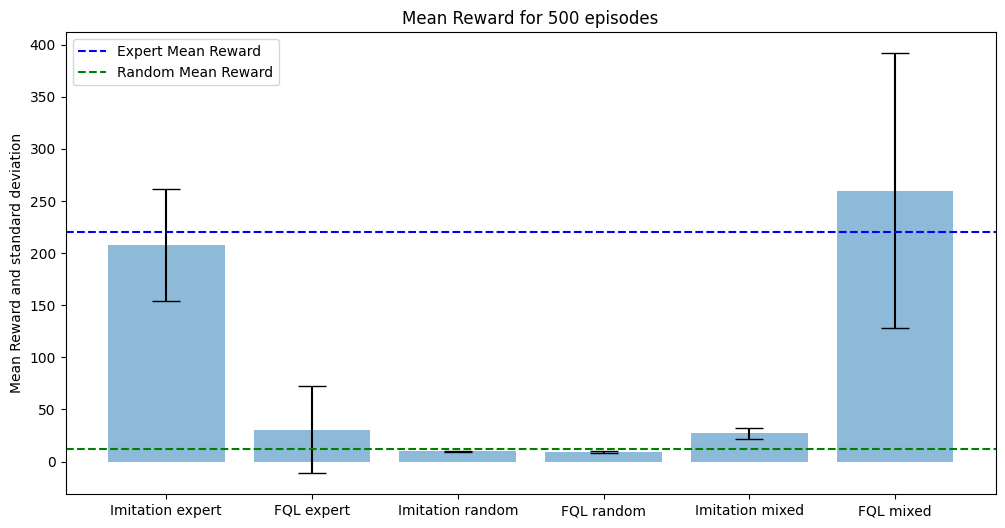

In [115]:
#for 500 episodes
fig, ax = plt.subplots()
ax.bar([0,1,2,3,4,5], [np.mean(rewards_optimal_5002), np.mean(q_rewards_optimal_5002), np.mean(rewards_random_5002), np.mean(q_rewards_random_5002), np.mean(rewards_mixed_5002), np.mean(q_rewards_mixed_5002)], yerr=[np.std(rewards_optimal_5002), np.std(q_rewards_optimal_5002), np.std(rewards_random_5002), np.std(q_rewards_random_5002), np.std(rewards_mixed_5002), np.std(q_rewards_mixed_5002)], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean Reward and standard deviation')
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['Imitation expert',"FQL expert" ,'Imitation random', 'FQL random', 'Imitation mixed', 'FQL mixed'], fontsize = 10)
ax.set_title('Mean Reward for 500 episodes')
ax.axhline(y=220, color='blue', linestyle='--', label='Expert Mean Reward')
ax.axhline(y=12, color='green', linestyle='--', label='Random Mean Reward')
ax.legend()
fig.set_size_inches(12, 6)